In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #displaying graphs
import tensorflow as tf
import keras
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#Load the dataset
df_train = pd.read_csv('train.csv', low_memory = False, parse_dates=["Date"]) 
df_store = pd.read_csv('store.csv')


#merge the datasets
df_com = pd.merge(df_train , df_store, on = 'Store', how = 'inner')

In [3]:
df_com.head(500)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,5,2015-07-31,10834,926,1,1,0,1,d,c,2780.0,6.0,2015.0,0,NaN,NaN,NaN
496,497,5,2015-07-31,11353,1248,1,1,0,1,a,c,1610.0,NaN,NaN,0,NaN,NaN,NaN
497,498,5,2015-07-31,7685,903,1,1,0,0,a,a,990.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
498,499,5,2015-07-31,7716,922,1,1,0,1,c,c,450.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [4]:
df_com.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [5]:
df_com['Promo2SinceWeek'].fillna(0, inplace=True)
df_com['Promo2SinceYear'].fillna(0, inplace=True)
df_com['PromoInterval'].fillna(0, inplace=True)

#Check for null values
df_com.isnull().sum()

C:\Users\Tsega KisPay\AppData\Local\Temp\ipykernel_15592\1717808567.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_com['Promo2SinceWeek'].fillna(0, inplace=True)
C:\Users\Tsega KisPay\AppData\Local\Temp\ipykernel_15592\1717808567.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

In [6]:
df_com['CompetitionDistance'].fillna(0, inplace=True)

# Identify rows where CompetitionDistance was filled with 0
filled_with_zero = df_com['CompetitionDistance'] == 0

# Fill corresponding rows in CompetitionOpenSinceMonth and CompetitionOpenSinceYear with 0
df_com.loc[filled_with_zero, 'CompetitionOpenSinceMonth'] = 0
df_com.loc[filled_with_zero, 'CompetitionOpenSinceYear'] = 0

#Check for null values
df_com.isnull().sum()

C:\Users\Tsega KisPay\AppData\Local\Temp\ipykernel_15592\2508146778.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_com['CompetitionDistance'].fillna(0, inplace=True)


Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    320706
CompetitionOpenSinceYear     320706
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

In [7]:
#Fill the rest of NA with mode
months = df_com['CompetitionOpenSinceMonth'].mode()
years = df_com['CompetitionOpenSinceYear'].mode()

df_com['CompetitionOpenSinceMonth'].fillna(months[0], inplace=True)
df_com['CompetitionOpenSinceYear'].fillna(years[0], inplace=True)

#Check for null values
df_com.isnull().sum()

C:\Users\Tsega KisPay\AppData\Local\Temp\ipykernel_15592\4293144329.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_com['CompetitionOpenSinceMonth'].fillna(months[0], inplace=True)
C:\Users\Tsega KisPay\AppData\Local\Temp\ipykernel_15592\4293144329.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [8]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [9]:
df_com['Date'] = pd.to_datetime(df_com['Date'])
df_chg = df_com.set_index(['Date'], drop=True)
df_chg.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [10]:
df_chg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1017209 non-null  float64
 11  CompetitionOpenSinceMonth  1017209 non-null  float64
 12  CompetitionOpenSinceYear   1017209 non-null  float64
 1

In [11]:
print(f"StateHoliday: {df_chg['StateHoliday'].nunique()}")
print(f"StoreType: {df_chg['StoreType'].nunique()}")
print(f"Assortment: {df_chg['Assortment'].nunique()}")
print(f"PromoInterval: {df_chg['PromoInterval'].nunique()}")

#For OneHotEncoding these variables will create in total 15 extra columns, So the question to be asked should they be dropped or converted?
#For now we will drop them and look back at it in the future

df_chg = df_chg.drop('StateHoliday', axis=1)
df_chg = df_chg.drop('StoreType', axis=1)
df_chg = df_chg.drop('Assortment', axis=1)
df_chg = df_chg.drop('PromoInterval', axis=1)



# #onehot encoding
# StateHolidayDummy = pd.get_dummies(df_chg['StateHoliday'])
# StoreTypeDummy = pd.get_dummies(df_chg['StoreType'])
# AssortmentDummy = pd.get_dummies(df_chg['Assortment'])
# PromoIntervalDummy = pd.get_dummies(df_chg['PromoInterval'])

StateHoliday: 4
StoreType: 4
Assortment: 3
PromoInterval: 4


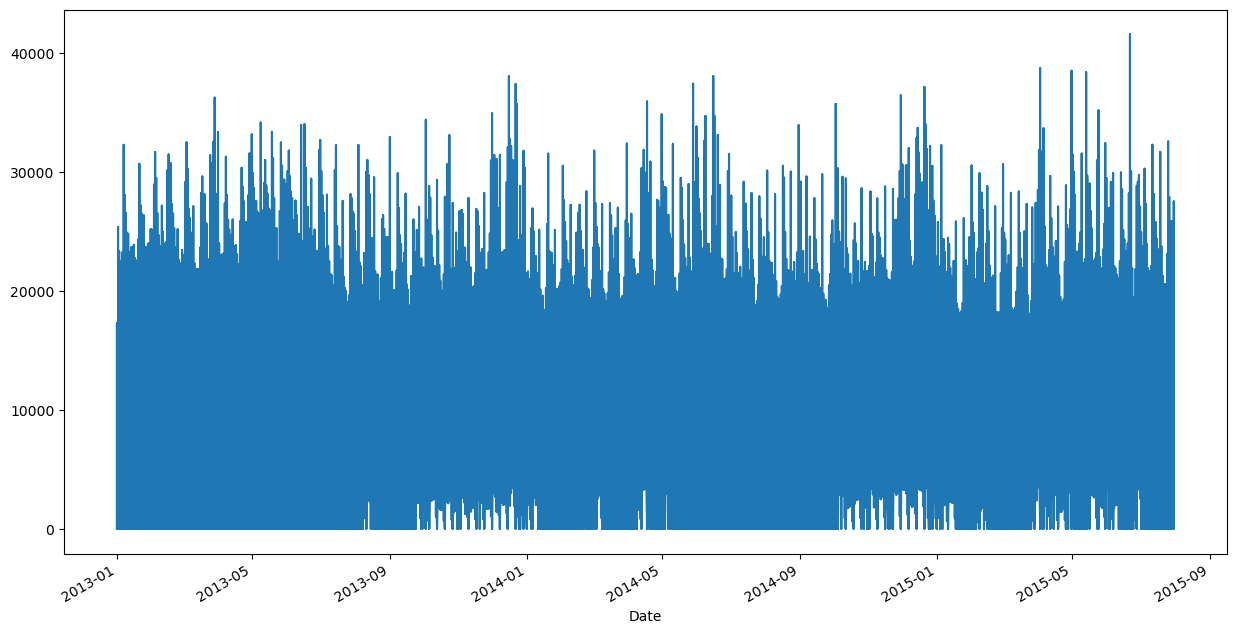

In [12]:
#Plot the timeseries
plt.figure(figsize=(15,8))
df_chg['Sales'].plot();

In [13]:
tss = TimeSeriesSplit(n_splits=2)

#Sort time frame by time and prepare features as data series
df_chg.sort_index(inplace=True)
X = df_chg.drop(labels=['Sales'], axis=1)
y = df_chg['Sales']

In [14]:
#Split Train and test data
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [15]:
X_train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13'],
              dtype='datetime64[ns]', name='Date', length=678140, freq=None)

In [16]:
X_test.index

DatetimeIndex(['2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13',
               ...
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=339069, freq=None)

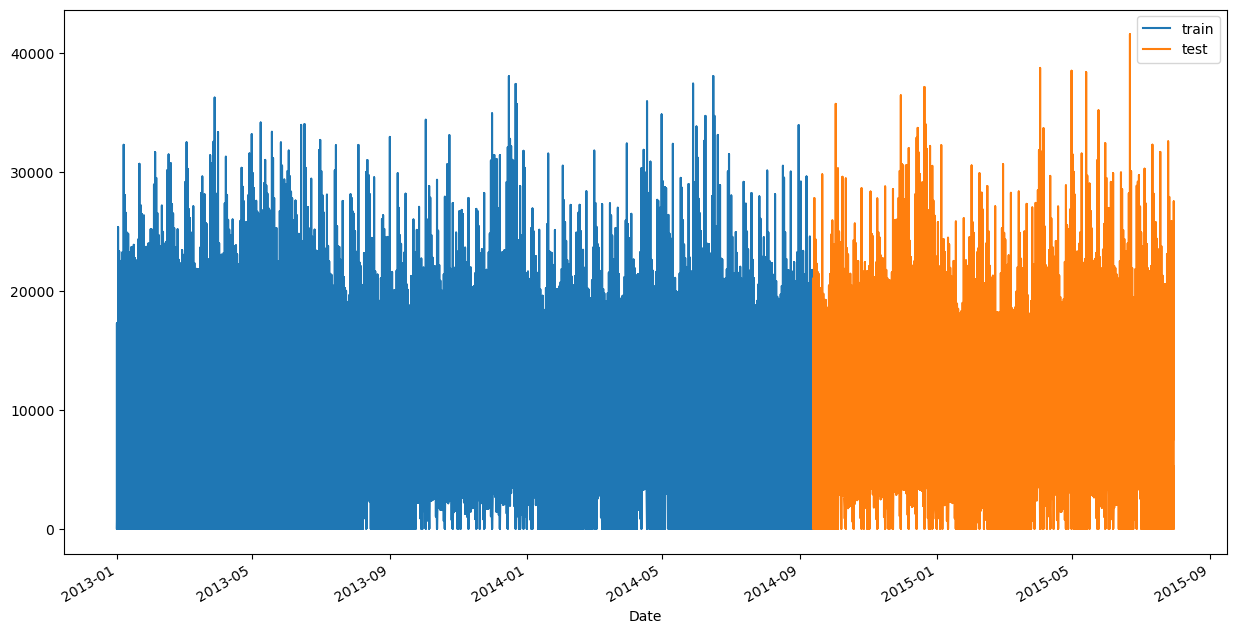

In [17]:
#Visualize the result of splitting
#y_train.groupby('Date').mean().plot()
#y_test.groupby('Date').mean().plot()
plt.figure(figsize=(15,8))
ax = y_train.plot()
y_test.plot(ax=ax)
plt.legend(['train', 'test'])

In [18]:
# #Reshape 1D array to 2D array
# y_train = np.array(y_train).reshape(-1,1)
# X_test = np.array(X_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1, 1)

In [19]:
# Scale the data
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_train_sc = scaler_x.fit_transform(X_train)
y_train_sc = scaler_y.fit_transform(y_train)
X_test_sc = scaler_x.fit_transform(X_test)
y_test_sc = scaler_y.fit_transform(y_test)

In [20]:
# Build the model simple nn
model = keras.Sequential()
model.add(Dense(12, input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dense(1))  # Output layer, 1 neuron for regression
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
#set seed
np.random.seed(455)

In [22]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
# history = model.fit(X_train_sc, y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

#Load time is too long so we will train a subset of the data

In [23]:
# Define the percentage of data to include in the subset
subset_percentage = 0.01

# Calculate the number of samples to include in the subset
num_samples = int(subset_percentage * len(X_train_sc))

num_samples_test = 41088

X_train_subset = X_train_sc[:num_samples, :]
y_train_subset = y_train_sc[:num_samples]

X_test_subset = X_test_sc[:num_samples_test, :]
y_test_subset = y_test_sc[:num_samples_test]

In [24]:
#41088 should the range be
len(X_test_subset)

41088

In [25]:
history = model.fit(X_train_subset, y_train_subset, epochs=50, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0166  
Epoch 2/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 6s 938us/step - loss: 0.0078
Epoch 3/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 6s 952us/step - loss: 0.0042
Epoch 4/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0033
Epoch 5/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0030
Epoch 6/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0028
Epoch 7/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0027
Epoch 8/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0027
Epoch 9/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0027
Epoch 10/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0027
Epoch 11/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 980us/step - loss: 0.0026
Epoch 12/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 988us/step - loss: 0.0026
Epoch 13/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0026
Epoch 14/50
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0026
Epoch 15/50
6781/67

In [26]:
#We predict our model and get R2 scores for train and test.
y_pred_test_nn = model.predict(X_test_subset)
y_train_pred_nn = model.predict(X_train_subset)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset, y_pred_test_nn)))

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
The R2 score on the Train set is:	0.791
The R2 score on the Test set is:	0.612


In [29]:
#Rescale for lSTM 
num_features = X_train_subset.shape[1]
num_samples = len(X_train_subset) - (len(X_train_subset) % num_features)

num_features_test = X_test_subset.shape[1]
num_samples_test = len(X_test_subset) - (len(X_test_subset) % num_features_test)

X_test_subset_lstm = X_test_subset[:num_samples, :]
y_test_subset_lstm = y_test_subset[:num_samples]

X_train_subset_lstm = X_train_subset[:num_samples, :]
y_train_subset_lstm = y_train_subset[:num_samples]

# Reshape data for LSTM input
X_train_subset_lstm = X_train_subset_lstm.reshape((-1, num_features, 1))
X_test_subset_lstm = X_test_subset_lstm.reshape((-1, num_features_test, 1))

In [30]:
# Ensure y_train_subset has the same number of samples as X_train_subset
num_samples_y = X_train_subset_lstm.shape[0]
y_train_subset_lstm = y_train_subset_lstm[:num_samples_y]

In [31]:
# Build the RNN model
rnn_model = keras.Sequential()
rnn_model.add(LSTM(50, input_shape=(num_features, 1)))
rnn_model.add(Dense(1))  # Output layer, 1 neuron for regression
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
np.random.seed(455)

In [33]:
history = rnn_model.fit(X_train_subset_lstm, y_train_subset_lstm, epochs=50, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0272
Epoch 2/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0082
Epoch 3/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0068
Epoch 4/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0053
Epoch 5/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0042
Epoch 6/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0033
Epoch 7/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0030
Epoch 8/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0028
Epoch 9/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0027
Epoch 10/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0026
Epoch 11/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0026
Epoch 12/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0025
Epoch 13/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0025
Epoch 14/50
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0024
Epoch 15/50
678

In [34]:
y_pred_test_lstm = rnn_model.predict(X_test_subset_lstm)
y_train_pred_lstm = rnn_model.predict(X_train_subset_lstm)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset_lstm, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset_lstm, y_pred_test_lstm)))

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The R2 score on the Train set is:	0.799
The R2 score on the Test set is:	0.339


In [35]:
#Compare test MSE of both models.
nn_test = model.evaluate(X_test_subset, y_test_subset, batch_size=1)
lstm_test = rnn_model.evaluate(X_test_subset_lstm, y_test_subset_lstm, batch_size=1)
print('NN: %f'%nn_test)
print('LSTM: %f'%lstm_test)

41088/41088 ━━━━━━━━━━━━━━━━━━━━ 40s 962us/step - loss: 0.0122
6780/6780 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0133
NN: 0.012368
LSTM: 0.020234


In [36]:
nn_y_pred_test = model.predict(X_test_subset)

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step


In [37]:
# Use the trained RNN model to predict sales values
y_pred = rnn_model.predict(X_test_subset_lstm)

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [38]:
y_pred_original_scale = scaler_y.inverse_transform(nn_y_pred_test)

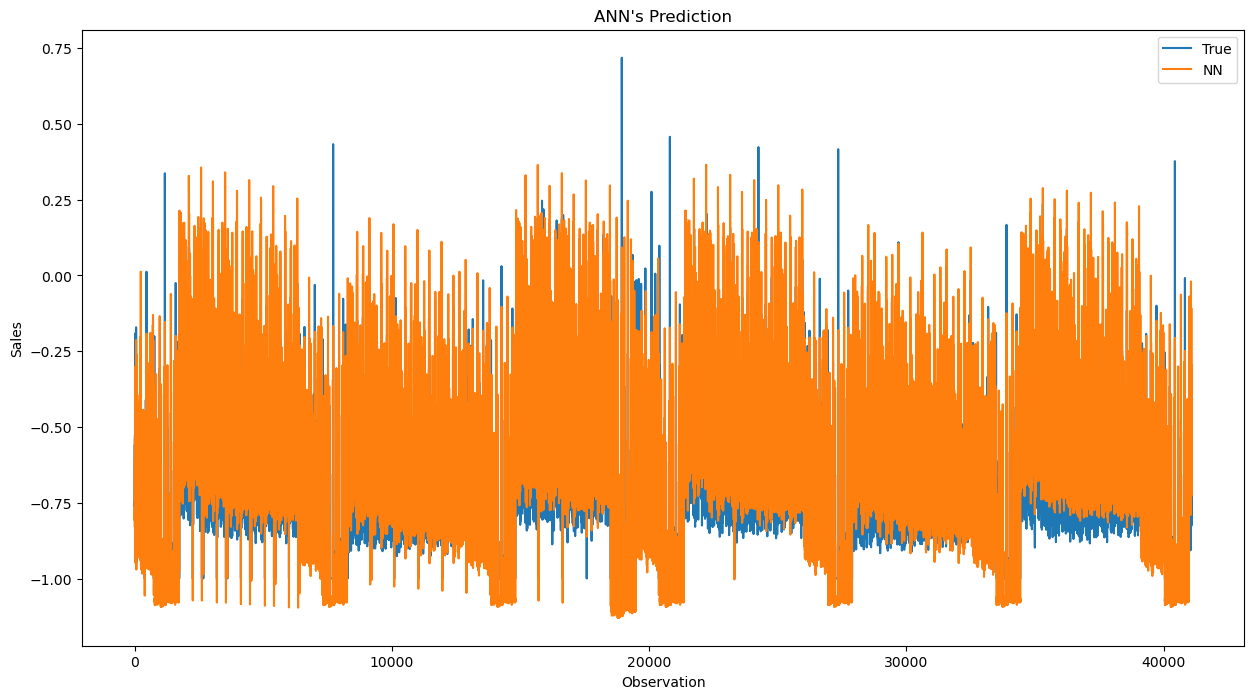

In [39]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset, label='True')
plt.plot(nn_y_pred_test, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show();

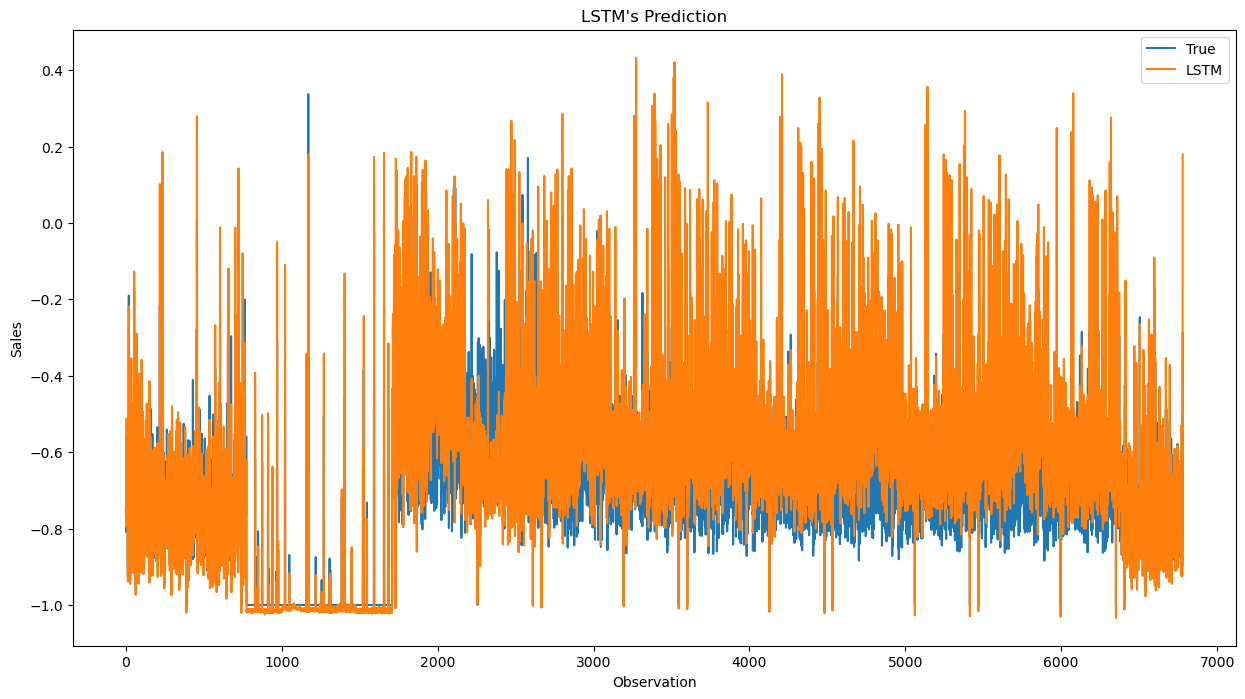

In [40]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset_lstm, label='True')
plt.plot(y_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show();

In [41]:
# Get the number of elements in the array
num_elements = len(y_pred_original_scale)

# Print or use the number of elements
print("Number of elements:", num_elements)

id_column = np.arange(1, num_elements + 1)

print(y_pred_original_scale)

Number of elements: 41088
[[ 4665.032 ]
 [ 3991.6853]
 [ 4865.2925]
 ...
 [ 7408.376 ]
 [ 7315.6953]
 [10942.78  ]]


In [42]:
#Kaggle Submission

kaggle_preds= pd.DataFrame({'Id': id_column, 
                          'Sales': y_pred_original_scale.flatten()})
kaggle_preds.to_csv("Sharoek_Reynethan_ArdaSubmission.csv", index = False)

In [43]:
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [44]:
# Save the model
model.save('model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')
